# Evaluating California Real Estate Market by Price-to-Rent Ratio

Categories of Interest:

Property Tax Rate (Average)

In [284]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [285]:
def rename_col(col_name):
    years_list = list(range(2010,2017))
    col_list = ["CountyName"]
    for year in years_list:
        col_list.append(col_name + "_{}".format(year))
    return col_list

def repeat_col(df,col_name):
    col_list = list(df.columns.values)
    for col,i in enumerate(col_list):
        if i != "CountyName":
            col_list[col] = col_name
    return col_list

def rename_headers(df,col_name):
    level_headers(df)
    df.columns = rename_col(col_name)

def level_headers(df):
    df.reset_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

## Reading & Cleaning Data

### 1) Price-to-rent data

In [286]:
pr = pd.read_csv("pricetorentratio.csv")
pr.head(3)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02
0,61639,10025,New York,NY,New York,New York,1,18.74,18.92,19.07,19.40,19.89,20.20,20.53,20.60,20.50,20.40,20.31,20.09,20.11,20.56,20.40,19.70,19.62,19.49,19.35,19.57,19.85,19.58,19.17,19.31,19.50,19.71,19.49,19.55,20.29,20.56,20.75,20.35,20.29,21.00,22.01,21.70,21.70,22.73,22.39,22.15,22.35,22.58,24.19,24.08,23.99,23.82,23.22,23.06,23.37,23.41,23.76,24.22,24.06,24.37,24.30,24.79,25.23,26.06,26.56,26.58,25.85,25.25,23.29,23.46,23.59,24.17,23.75,22.05,22.89,23.61,24.41,24.76,24.67,25.03,25.17,24.75,24.77,24.91,24.60,25.48,26.20,26.33,26.48,26.11,26.52,26.48,26.38,26.27,26.01
1,84654,60657,Chicago,IL,Chicago,Cook,2,13.27,13.20,13.20,13.31,13.36,13.50,13.23,13.10,12.98,12.68,12.58,12.46,12.46,12.35,12.34,12.42,12.22,11.96,11.93,11.90,11.84,11.88,12.16,12.15,12.08,12.11,12.18,12.05,12.03,11.96,12.01,12.18,12.00,11.89,11.78,11.96,12.28,12.47,12.56,12.84,12.94,12.79,12.61,12.57,12.51,12.32,12.23,12.26,12.33,12.30,12.36,12.57,12.43,12.48,12.40,12.38,12.37,12.36,12.33,12.39,12.27,12.30,12.41,12.36,12.45,12.36,12.36,12.53,12.45,12.45,12.38,12.40,12.52,12.68,12.85,12.99,13.07,13.12,13.11,13.02,12.85,12.80,12.75,12.70,12.78,13.00,13.05,13.05,13.10
2,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,3,9.51,9.51,9.47,9.43,9.45,9.47,9.43,9.38,9.30,9.23,9.18,9.15,9.15,9.18,9.19,9.18,9.17,9.15,9.13,9.11,9.11,9.11,9.11,9.13,9.16,9.24,9.34,9.38,9.38,9.43,9.51,9.55,9.60,9.64,9.69,9.73,9.81,9.84,9.87,9.91,9.85,9.84,10.02,10.13,10.24,10.24,10.28,10.31,10.38,10.61,10.75,10.82,10.89,10.98,11.06,11.18,11.31,11.45,11.51,11.61,11.70,11.77,11.97,12.12,12.26,12.40,12.40,12.41,12.49,12.55,12.58,12.66,12.70,12.80,12.86,12.94,13.04,13.20,13.28,13.37,13.33,13.25,13.25,13.40,13.57,13.61,13.65,13.68,13.73


In [287]:
# extracting CA real estate data from US real estate data using CA zip codes
# load california zip codes
ca_zip = pd.read_csv("CAzipcodes.csv")
#ca_zip.head(1)

In [288]:
# change zip_code column name to match "RegionName" in price-to-rent dataset
ca_zip.columns = ["RegionName"]
#ca_zip.head(1)

In [289]:
# merge ca_zip & pr to extract CA price-to-rent data, save merged dataframe into new variable "ca_pr"
ca_pr = pd.merge(pr,ca_zip)

year_list = list(range(2010,2019))
for year in year_list:
    ca_pr[str(year)] = 0

index = 0
for year in ca_pr.iloc[:,7:].columns.values:
    if "-01" in year:
        index += 1
    else:
        ca_pr[str(year_list[index])] += ca_pr[year]

ca_pr = ca_pr[["CountyName","2010","2011","2012","2013","2014","2015","2016"]]

ca_pr = ca_pr.groupby(["CountyName"]).mean()
rename_headers(ca_pr,"Price_to_Rent")

for year in ca_pr.iloc[:,1:].columns.values:
    if "_2010" in year:
        ca_pr[year] = ca_pr[year].apply(lambda x: (x*4)/12)
    else:
        ca_pr[year] = ca_pr[year].apply(lambda x: x/12)
        
ca_pr.head(3)
#ca_pr.dtypes

,CountyName,Price_to_Rent_2010,Price_to_Rent_2011,Price_to_Rent_2012,Price_to_Rent_2013,Price_to_Rent_2014,Price_to_Rent_2015,Price_to_Rent_2016
0,Alameda,18.083926,15.286870,15.722685,18.498389,18.413870,17.758648,17.951500
1,Amador,12.049048,11.358333,13.574286,14.663333,14.129167,14.327262,13.528929
2,Butte,11.349167,11.212153,11.354653,12.230000,13.130903,13.066250,13.371111


### 2) Unemployment Rate (%) 2010-2016

In [290]:
path = os.getcwd()
files = os.listdir(path)
lfd_xlsx = [f for f in files if f[-4:]=='xlsx' and f[0:3]=='lfd']
lfd = pd.DataFrame()
for f in lfd_xlsx:
    data = pd.read_excel(f)
    lfd = lfd.append(data)
    
lfd.columns = lfd.iloc[4]
lfd.columns = ['LAUS','2011','2012','2013','2014','2015','2016','STATEFIPSCODE','COUNTYFIPSCODE','COUNTYNAME/STATEABBR','YEAR','_','LABORFORCE','EMPLOYED','UNEMPLOYED','UNEMPLOYMENTRATE(%)']
lfd = lfd.iloc[5:]
lfd['CountyName'],lfd['STATEABBR'] = lfd['COUNTYNAME/STATEABBR'].str.split(',',1).str
lfd = lfd.drop(lfd.columns[[0,1,2,3,4,5,6,7,8,9,11]],axis=1)
lfd = lfd.dropna(how="any")
lfd = lfd.loc[lfd['STATEABBR']==' CA']

In [291]:
# changing county names to match price-to-rent county names for merge
lfd["CountyName"] = lfd["CountyName"].apply(lambda x: ' '.join([w for w in x.split() if not 'County' in w]))
# extract unemployment rate (%) per year
unemployment_rate = lfd.pivot_table(index="CountyName",columns="YEAR",values=["UNEMPLOYMENTRATE(%)"],aggfunc="first")
rename_headers(unemployment_rate,"UnemploymentRate(%)")
#unemployment_rate.columns.values[1:8] = rename_col()
unemployment_rate.head(3)
#print(lfd_year.to_string())

,CountyName,UnemploymentRate(%)_2010,UnemploymentRate(%)_2011,UnemploymentRate(%)_2012,UnemploymentRate(%)_2013,UnemploymentRate(%)_2014,UnemploymentRate(%)_2015,UnemploymentRate(%)_2016
0,Alameda,10.9,10.1,8.7,7.2,5.8,4.7,4.2
1,Alpine,12.9,12.8,11.2,9.7,8.2,7.3,6.5
2,Amador,14.1,13.6,12.3,10.3,8.3,6.6,5.9


### 3) Population Total 2010-2016

In [292]:
f = pd.ExcelFile("CAcountypop.xlsx")
pop = pd.DataFrame()
year = 2010
for sheet in f.sheet_names:
    if "E5CountyState" in sheet and "2017" not in sheet:
            sub_pop = pd.read_excel(f,sheet,skiprows=3).assign(Year=year)
            pop = pop.append(sub_pop)
            year += 1
    
pop = pop[["COUNTY","Total","Total.1","Vacancy Rate","Year"]]
pop.columns = ["CountyName","Population Total","Housing Units Total","Vacancy Rate","Year"]
pop = pop.drop(pop.index[[59]])
pop = pop.dropna(how="any")
#display(pop)
#print(list(pop.columns.values))
#print(pop.to_string())

In [293]:
# extract population totals per year
pop_year = pop.pivot_table(index="CountyName",columns="Year",values=["Population Total"],aggfunc="first")
rename_headers(pop_year,"Total_Population")
#pop_year.columns.values[1:8] = rename_col()
pop_year.head(3)
#display(pop_year)

,CountyName,Total_Population_2010,Total_Population_2011,Total_Population_2012,Total_Population_2013,Total_Population_2014,Total_Population_2015,Total_Population_2016
0,Alameda,1510271.0,1525695.0,1543027.0,1567091.0,1588348.0,1611318.0,1629233.0
1,Alpine,1175.0,1169.0,1166.0,1164.0,1163.0,1163.0,1160.0
2,Amador,38091.0,38011.0,37945.0,37304.0,37815.0,37764.0,37667.0


 ### 3) Vacancy Rate 2010-2016

In [294]:
vacancy_year = pop.pivot_table(index="CountyName",columns="Year",values=["Vacancy Rate"],aggfunc="first")
rename_headers(vacancy_year,"Vacancy_Rate")
#vacancy_year.columns.values[1:8] = rename_col()
vacancy_year.head(3)

,CountyName,Vacancy_Rate_2010,Vacancy_Rate_2011,Vacancy_Rate_2012,Vacancy_Rate_2013,Vacancy_Rate_2014,Vacancy_Rate_2015,Vacancy_Rate_2016
0,Alameda,0.064203,0.063045,0.057916,0.051747,0.050178,0.048556,0.041431
1,Alpine,0.717614,0.717701,0.718661,0.719932,0.720406,0.720970,0.722722
2,Amador,0.192047,0.192977,0.197228,0.201992,0.203116,0.204261,0.204238


### 4) Housing Units 2010-2016

In [295]:
housing_units_year = pop.pivot_table(index="CountyName",columns="Year",values=["Housing Units Total"],aggfunc="first")
rename_headers(housing_units_year,"Total_Housing_Units")
#housing_units_year.columns.values[1:8] = rename_col()
housing_units_year.head(3)

,CountyName,Total_Housing_Units_2010,Total_Housing_Units_2011,Total_Housing_Units_2012,Total_Housing_Units_2013,Total_Housing_Units_2014,Total_Housing_Units_2015,Total_Housing_Units_2016
0,Alameda,581372.0,582727.0,584049.0,586474.0,588948.0,591235.0,593662.0
1,Alpine,1760.0,1757.0,1763.0,1771.0,1774.0,1774.0,1778.0
2,Amador,18032.0,18054.0,18111.0,18174.0,18167.0,18163.0,18170.0


### 5) Crime Rate 2010-2016

In [296]:
crime = pd.read_csv("CAcrimes.csv",sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
# change dtype for dataframe fr. objects to integers
crime = crime.apply(pd.to_numeric,errors="ignore")
# change persistent object types to integers 
crime_obj = ["TotalStructural_sum","TotalMobile_sum","TotalOther_sum","GrandTotal_sum","GrandTotClr_sum"]
for obj in crime_obj:
    crime[obj] = pd.to_numeric(crime[obj],errors="coerce")
# sum selected column data for total crime
col_list = list(crime)
col_list = [col for col in col_list if col not in {'Year','County','NCICCode'}]
crime["Total Crime"] = crime[col_list].sum(axis=1)
# select only Years 2010-2016
crime = crime[(crime["Year"] >= 2010) & (crime["Year"] < 2017)]
crime = crime.rename(columns={"County":"CountyName"})
crime["CountyName"] = crime["CountyName"].apply(lambda x: ' '.join([w for w in x.split() if not 'County' in w]))
#print(col_list)
#crime.head(3)
#crime.dtypes

In [297]:
# consolidate total crimes per year
crime_year = crime.pivot_table(index="CountyName",columns="Year",values=["Total Crime"],aggfunc="first")
level_headers(crime_year)
#crime_year.head(3)
#display(crime_year)

In [298]:
# calculate crime rate 
crime_rate = crime_year.iloc[:,1:]/pop_year.iloc[:,1:].values
#crime_rate.columns = rename_col()
rename_headers(crime_rate,"Crime_Rate")
crime_rate["CountyName"] = crime_year["CountyName"]
crime_rate.head(3)
#display(crime_rate)

,CountyName,Crime_Rate_2010,Crime_Rate_2011,Crime_Rate_2012,Crime_Rate_2013,Crime_Rate_2014,Crime_Rate_2015,Crime_Rate_2016
0,Alameda,0.008299,0.008150,0.008993,0.008165,0.007104,0.006690,0.007222
1,Alpine,0.305532,0.415740,0.179245,0.152921,0.110060,0.177988,0.144828
2,Amador,0.069386,0.082003,0.068178,0.066481,0.056776,0.050763,0.056761


### 6) School Total 2010-2016

#### A) Private Schools

In [299]:
ps_xls = [f for f in files if f[-3:]=='xls' and f[0:2]=='ps']
ps_data = pd.DataFrame()
year = 2010
for f in ps_xls:
    data = pd.read_excel(f,skiprows=3).assign(Year=year)
    ps_data = ps_data.append(data)
    year += 1

ps_data = ps_data[["County","Year"]]
ps_data = ps_data.dropna(how="any")
ps_data["Private_School_Count"] = 1
ps_data = ps_data.rename(columns={"County":"CountyName"})
#ps_data.head(3)
#display(ps_data)
#ps_data.head(3)

In [300]:
# modify data to extract number of private schools per year
ps = ps_data.pivot_table(index="CountyName",columns="Year",values=["Private_School_Count"],aggfunc="sum")
ps = ps.fillna(0)
ps_year = ps
level_headers(ps_year)
ps_year = ps_year.drop(ps_year.index[[51]])
#ps_year.head(3)
#display(ps_year)
#print(ps_year.to_string())

#### B) Public Schools

In [301]:
pubs_data = pd.read_excel("pubschls.xlsx")

pubs_data = pubs_data[["County","OpenDate","ClosedDate","LastUpDate"]]
pubs_data["TMP"] = pubs_data.OpenDate.values # create temporary column out of the index
pubs_data = pubs_data[pubs_data.TMP.notnull()] # remove all NaT values
pubs_data.drop(["TMP"], axis=1, inplace=True) # delete temporary column 
pubs_data["OpenYear"] = pd.DatetimeIndex(pubs_data['OpenDate']).year
pubs_data["ClosedYear"] = pd.DatetimeIndex(pubs_data['ClosedDate']).year
for year in range(2010, 2017):
    # Create a column of 0s
    pubs_data[year] = 0
    # Where the year is between OpenYear and ClosedYear (or closed year is NaN) set it to 1
    pubs_data.loc[(pubs_data['OpenYear'] <= year) & ((pubs_data['ClosedYear'].isnull()) | (pubs_data['ClosedYear'] >= year)), year] += int(1)
pubs_data = pubs_data.rename(columns={"County":"CountyName"})
#pubs_data.head(3)

In [302]:
# consolidate number of public schools per year
pubs_year = pubs_data[["CountyName",2010,2011,2012,2013,2014,2015,2016]]
pubs_year = pubs_year.groupby(["CountyName"]).sum()
level_headers(pubs_year)
#pubs_year.head(3)
#display(pubs_year)

#### C) Total Number of Schools

In [303]:
col_list = ["CountyName","2010","2011","2012","2013","2014","2015","2016"]
pub = pubs_year
pub.columns = col_list
priv = ps
#priv.reset_index(inplace=True)
priv.columns = priv.columns.get_level_values(0)
priv.columns = col_list

# add public schools and private schools together to get total number of schools per year
sch_total = pub.iloc[:,1:].add(priv.iloc[:,1:],fill_value=0)

rename_headers(sch_total,"Total_Schools")
sch_total["CountyName"] = pub["CountyName"]
#display(sch_total)
sch_total.head(3)

,CountyName,Total_Schools_2010,Total_Schools_2011,Total_Schools_2012,Total_Schools_2013,Total_Schools_2014,Total_Schools_2015,Total_Schools_2016
0,Alameda,580.0,568.0,576.0,560.0,557.0,556.0,549.0
1,Alpine,7.0,4.0,4.0,4.0,3.0,3.0,3.0
2,Amador,18.0,18.0,16.0,16.0,17.0,16.0,17.0


### 7) Building Permits 2010-2016

In [304]:
bp_xls = [f for f in files if f[-3:]=='csv' and f[0:2]=='bp']
bp_data = pd.DataFrame()
for f in bp_xls:
    data = pd.read_csv(f,sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
    bp_data = bp_data.append(data)

bp_data = bp_data.iloc[2:,:]
bp_data = bp_data[["Survey","FIPS","County","Unnamed: 6","Unnamed: 9","Unnamed: 12","Unnamed: 15"]]
# extract CA building permits fr. US data
bp_data["FIPS"] = bp_data["FIPS"].apply(pd.to_numeric,errors="coerce")
bp_data = bp_data[bp_data["FIPS"]==6]
bp_data.columns = ["Year","FIPS","CountyName","1_unit_bldgs","2_unit_bldgs","3-4_unit_bldgs","5+_unit_bldgs"]
#change data type for bldg columns fr. object to integer
for col in bp_data.columns.values[3:]:
    bp_data[col] = bp_data[col].apply(pd.to_numeric,errors="coerce")
# sum bldg columns to get total building permits column 
col_list = list(bp_data)
col_list = [col for col in col_list if col not in {'Year','CountyName'}]
bp_data["Total_bldgs"] = bp_data[col_list].sum(axis=1)
bp_data["CountyName"] = bp_data["CountyName"].apply(lambda x: ' '.join([w for w in x.split() if not 'County' in w]))
#print(list(bp_data.columns.values))
bp_data.head(3)

,Year,FIPS,CountyName,1_unit_bldgs,2_unit_bldgs,3-4_unit_bldgs,5+_unit_bldgs,Total_bldgs
180,2010,6.0,Alameda,879,22,8,26,941.0
181,2010,6.0,Alpine,4,0,0,0,10.0
182,2010,6.0,Amador,29,0,0,0,35.0


In [305]:
# extract building permits per county per year
bp_year = bp_data.pivot_table(index="CountyName",columns="Year",values=["Total_bldgs"],aggfunc="sum")
rename_headers(bp_year,"Total_Building_Permits")
#bp_year.columns.values[1:8] = rename_col()
bp_year.head(3)
#display(bp_year)

,CountyName,Total_Building_Permits_2010,Total_Building_Permits_2011,Total_Building_Permits_2012,Total_Building_Permits_2013,Total_Building_Permits_2014,Total_Building_Permits_2015,Total_Building_Permits_2016
0,Alameda,941.0,898.0,1479.0,1480.0,1659.0,2039.0,2548.0
1,Alpine,10.0,9.0,7.0,6.0,9.0,10.0,8.0
2,Amador,35.0,86.0,116.0,20.0,28.0,33.0,47.0


### 8) Average Property Tax Rate 2010-2016

In [306]:
ptax_xlsx = [f for f in files if f[-4:]=='xlsx' and f[0:2]=='pt']
ptax_data1 = pd.DataFrame()
ptax_data2 = pd.DataFrame()
year = 2010
for f in ptax_xlsx:
    if "10" in f or "11" in f:
        data = pd.read_excel(f,skiprows=8).assign(Year=year)
        ptax_data1 = ptax_data1.append(data)
    else:
        data = pd.read_excel(f,skiprows=4).assign(Year=year)
        ptax_data2 = ptax_data2.append(data)
    year += 1

ptax_data1 = ptax_data1[["1","8","Year"]]
ptax_data1.columns = ["CountyName","Average Property Tax Rate","Year"]

ptax_data2 = ptax_data2[["County  ","Average \ntax rate","Year"]]
ptax_data2.columns = ["CountyName","Average Property Tax Rate","Year"]

ptax_data = pd.DataFrame()
ptax_data = ptax_data.append(ptax_data1)
ptax_data = ptax_data.append(ptax_data2)
#display(ptax_data1)
#ptax_data1.head(3)
#print(list(ptax_data2.columns.values))
#ptax_data.head(3)

In [307]:
# extract average property tax per year 
ptax_year = ptax_data.pivot_table(index="CountyName",columns="Year",values=["Average Property Tax Rate"],aggfunc="first")
ptax_year = ptax_year.dropna(how="any")
rename_headers(ptax_year,"Average_Property_Tax")
#ptax_year.columns.values[1:8] = rename_col()
ptax_year.head(3)
#display(ptax_year)

,CountyName,Average_Property_Tax_2010,Average_Property_Tax_2011,Average_Property_Tax_2012,Average_Property_Tax_2013,Average_Property_Tax_2014,Average_Property_Tax_2015,Average_Property_Tax_2016
0,Alameda,0.01207,0.01215,0.01222,0.01222,0.01224,0.01224,0.01224
1,Alpine,0.01000,0.01000,0.01000,0.01000,0.01000,0.01000,0.01000
2,Amador,0.01017,0.01017,0.01017,0.01017,0.01017,0.01017,0.01017


### 9) Job Growth 2010-2016

In [308]:
bg_xls = [f for f in files if f[-3:]=='xls' and f[0:2]=='bg']
bg_data = pd.DataFrame()
year = 2010
for f in bg_xls:
    data = pd.read_excel(f,skiprows=7).assign(Year=year)
    bg_data = bg_data.append(data)
    year += 1

bg_data = bg_data.drop(bg_data.columns[[0,1,12,13,14]],axis=1)
bg_data = bg_data.dropna(how="any")
bg_data = bg_data.rename(columns={"Counties":"CountyName"})

col_list = list(bg_data)
col_list = [col for col in col_list if col not in {'Year','CountyName'}]
bg_data["Total_Businesses"] = bg_data[col_list].sum(axis=1)
#bg_data.head(10)
#print(bg_data.columns.values)

In [309]:
bg_year = bg_data.pivot_table(index="CountyName",columns="Year",values=["Total_Businesses"],aggfunc="sum")
rename_headers(bg_year,"Total_Businesses")
#bg_year.columns.values[1:8] = rename_col()
bg_year.head(3)

,CountyName,Total_Businesses_2010,Total_Businesses_2011,Total_Businesses_2012,Total_Businesses_2013,Total_Businesses_2014,Total_Businesses_2015,Total_Businesses_2016
0,Alameda,49015.0,50785.0,47291.0,49182.0,50606.0,52579.0,54397.0
1,Alpine,72.0,84.0,91.0,87.0,90.0,85.0,84.0
2,Amador,909.0,910.0,880.0,900.0,916.0,947.0,960.0


## Merge Data for Data Visualization (PairPlot)

Note: create a test pairplot (take 2010 columns in each dataframe and append to new dataframe for pairplot), find correlations, if any exist create a new dataframe with 2010-2016 average and create a new pairplot) 
*pairplot only plots numerical values, each point on plot represents a county 

1) Come up with graphs (histograms, scatterplots, boxplots) to find relationships between two datasets
2) Use statistical analysis to prove a positive or negative reltationships between the two datasets (pvalue, ttestsm etc.) 

https://github.com/maf5509/accident_capstone/blob/master/Untitled.ipynb (project example)

In [310]:
# 2010-2016 averages
# avg price-to-rent ratio 
ca_pr["avg_price_to_rent"] = ca_pr.iloc[:,7:82].mean(axis=1)
# avg unemployment rate 
unemployment_rate["avg_unemployment_rate"] = unemployment_rate.mean(axis=1)
# avg population total
pop_year["avg_pop_total"] = pop_year.mean(axis=1)
# avg vacancy rate 
vacancy_year["avg_vacancy_rate"] = vacancy_year.mean(axis=1)
# avg housing units
housing_units_year["avg_housing_units"] = housing_units_year.mean(axis=1)
# avg crime rate
crime_rate["avg_crime_rate"] = crime_rate.mean(axis=1)
# avg total schools
sch_total["avg_school_total"] = sch_total.mean(axis=1)
# avg building permits
bp_year["avg_building_permits"] = bp_year.mean(axis=1)
# avg property tax
ptax_year["avg_property_tax"] = ptax_year.mean(axis=1)
# avg job growth
bg_year["avg_job_growth"] = bg_year.mean(axis=1)

ca_market_data = pd.DataFrame()
ca_market_data["CountyName"] = crime_rate["CountyName"]
data_list = [ca_pr,unemployment_rate,pop_year,vacancy_year,housing_units_year,crime_rate,sch_total,bp_year,ptax_year,bg_year]
for data in data_list:
    col_list = list(data.columns.values)
    ca_market_data[col_list[-1]] = data[col_list[-1]]

ca_market_data = ca_market_data.dropna(how="any")
display(ca_market_data)
#ca_pr.iloc[:,7:83].head(3)

,CountyName,avg_price_to_rent,avg_unemployment_rate,avg_pop_total,avg_vacancy_rate,avg_housing_units,avg_crime_rate,avg_school_total,avg_building_permits,avg_property_tax,avg_job_growth
0,Alameda,17.951500,7.371429,1.567855e+06,0.053868,5.869239e+05,0.007803,563.714286,1577.714286,0.012197,5.055071e+04
1,Alpine,13.528929,9.800000,1.165714e+03,0.719715,1.768143e+03,0.212331,4.000000,8.428571,0.010000,8.471429e+01
2,Amador,13.371111,10.157143,3.779957e+04,0.199408,1.812443e+04,0.064335,16.857143,52.142857,0.010170,9.174286e+02
3,Butte,13.214286,10.328571,2.223863e+05,0.091254,9.696800e+04,0.027829,121.285714,322.428571,0.010660,7.061000e+03
4,Calaveras,11.200000,10.100000,4.541771e+04,0.324526,2.808171e+04,0.087824,30.714286,77.428571,0.011063,1.157429e+03
5,Colusa,16.281181,18.542857,2.169529e+04,0.104610,7.970000e+03,0.054130,21.428571,40.857143,0.010376,1.242541e+06
6,Contra Costa,10.886667,7.614286,1.085512e+06,0.053100,4.045516e+05,0.001741,378.857143,1472.000000,0.011474,7.205714e+02
7,Del Norte,14.660641,11.128571,2.772371e+04,0.123868,1.123743e+04,0.084128,23.571429,29.142857,0.010547,2.660971e+04
8,El Dorado,12.197866,8.628571,1.819069e+05,0.211705,8.873486e+04,0.059223,88.285714,316.285714,0.010647,7.190000e+02
9,Fresno,10.962083,13.242857,9.568353e+05,0.079370,3.209993e+05,0.003836,409.571429,1944.285714,0.011577,4.420714e+03


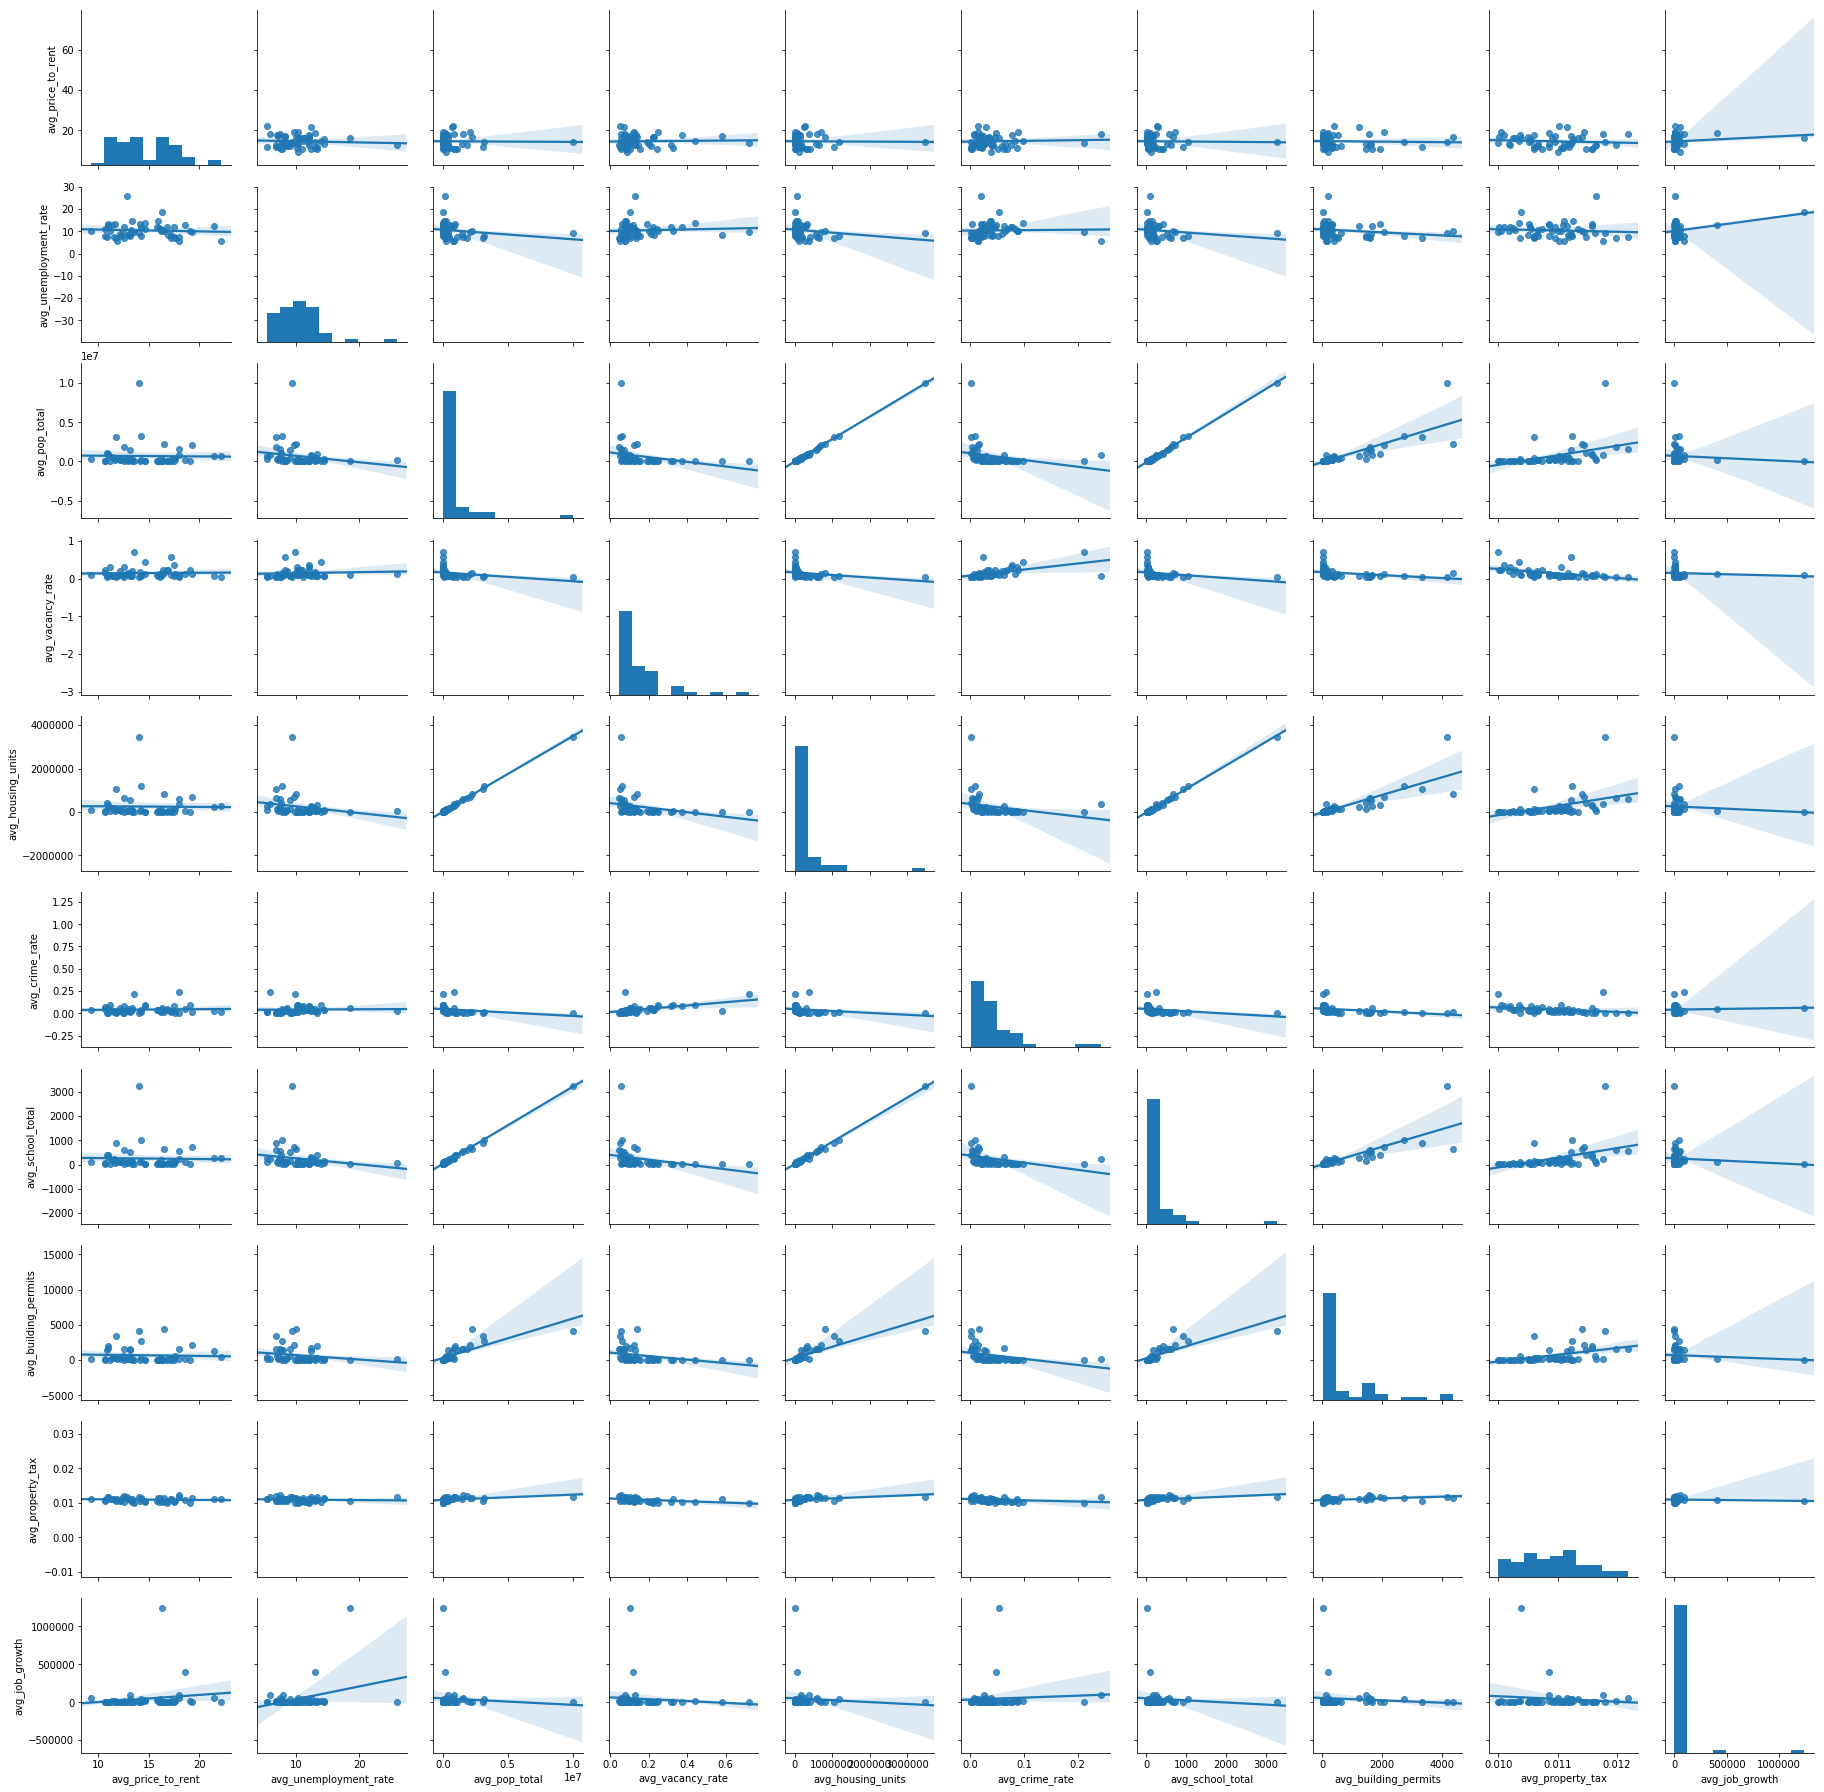

In [311]:
# plot dataframe into seaborn pairplot to find potential correlations between data (avg. 2010-2016)
plt.rcParams['figure.figsize']=(20,20)
sns.pairplot(ca_market_data,kind="reg")

Possible correlations:

A) Positive

Price-to-rent vs : Population Total, Housing Units, School Total, Building Permits, Property Tax

B) Negative

Price-to-rent vs : Unemployment Rate, Vacancy Rate, Crime Rate

## Comparing Data (2010-2016) using Central Limit Theorem

### Price-to-rent vs :

In [312]:
#i = pop_year["CountyName"].values.squeeze()
#j = ca_pr["CountyName"].values.squeeze()
#pop1 = pd.DataFrame(np.intersect1d(i, j))
#pop_year["CountyName"] = pop1.copy(deep=True)
#pop_year = pop_year.dropna(how="any")
#print(pop_year["CountyName"])

#### 1) Total Population

In [313]:
from scipy.stats.stats import pearsonr

# remove rows in Total Population CountyName that does not match with Price-to-Rent CountyName rows
i = pop_year["CountyName"].values.squeeze()
j = ca_pr["CountyName"].values.squeeze()
pop1 = pd.DataFrame(np.intersect1d(i, j))

# select all data other than CountyName and avg columns
df1 = ca_pr.iloc[:,1:(len(ca_pr.columns)-1)]
df2 = pop1.iloc[:,1:(len(pop_year.columns)-1)]

# find p-value using pearsonr correlation coefficient 
coeffmat = np.zeros((df1.shape[1], df2.shape[1]))
pvalmat = np.zeros((df1.shape[1], df2.shape[1]))

for i in range(df1.shape[1]):    
    for j in range(df2.shape[1]):        
        corrtest = pearsonr(df1[df1.columns[i]], df2[df2.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=df2.columns, index=df1.columns)
print(dfcoeff)

Empty DataFrame
Columns: []
Index: [Price_to_Rent_2010, Price_to_Rent_2011, Price_to_Rent_2012, Price_to_Rent_2013, Price_to_Rent_2014, Price_to_Rent_2015, Price_to_Rent_2016]
